In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


###  Import the data

In [2]:
sns.set(style="whitegrid") # grafikler için

df = pd.read_csv("googleplaystore.csv")

df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


### Data Pre-Review

In [3]:
df.info()

df.isnull().sum() # Eksik veri kontrolü, Hangi sütunda kaç eksik veri var?


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

### Data Cleaning
🔹 Rating → sayıya çevrilip eksik olanlar silinecek
🔹 Installs → Sayıya çevrilecek
🔹 Size → "Varies with device" gibi veriler ayıklanacak
🔹 Kategorik veriler → Sonra One-Hot Encoding yapılacak

In [5]:
# rating, kullanıcılardan aldığı ortalama puanı
df['Rating'].describe() # rating sütunu için istatiksel bilgiler

count    9367.000000
mean        4.193338
std         0.537431
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max        19.000000
Name: Rating, dtype: float64

In [6]:
df = df[df['Rating'] <= 5.0] # Rating 5.0'dan büyük olamaz varsa hatalı veridir

df = df.dropna(subset=['Rating']) # Eksik (NaN) rating değerler

df['Rating'].isnull().sum()


np.int64(0)

In [11]:
# "+" ve "," karakterlerini kaldır ve sayıya çevir
df['Installs'] = df['Installs'].str.replace(',', '').str.replace('+', '', regex=False)

# Bazı hatalı verileri temizleyelim (örneğin 'Free' gibi string'ler varsa)
df = df[df['Installs'].str.isnumeric()]

# Son olarak sayıya çevir
df['Installs'] = df['Installs'].astype(int)


In [12]:
#"1,000+", "10,000,000+", "Free" vb. bunları sayıya dönüştürmemiz gerekiyor
def convert_size(size):
    if size.endswith('M'):
        return float(size[:-1]) * 1_000_000
    elif size.endswith('k'):
        return float(size[:-1]) * 1_000
    else:
        return np.nan  # "Varies with device" gibi

# Yeni sütun oluşturalım
df['Size_converted'] = df['Size'].replace('Varies with device', np.nan)
df['Size_converted'] = df['Size_converted'].dropna().apply(convert_size)

# Kalan eksik değerleri ortalama ile dolduruldu
mean_size = df['Size_converted'].mean()
df['Size_converted'] = df['Size_converted'].fillna(mean_size)


In [13]:
#Size sütunu — uygulama boyutu -> Tüm değerleri byte cinsinden float sayıya çevirerek birimleştirmek
def convert_size(size):
    if size.endswith('M'):
        return float(size[:-1]) * 1_000_000
    elif size.endswith('k'):
        return float(size[:-1]) * 1_000
    else:
        return np.nan  # "Varies with device" gibi -> sayıya çevrilemediği için NaN (eksik veri)

# Yeni sütun oluşturalım
df['Size_converted'] = df['Size'].replace('Varies with device', np.nan) #"Varies with device" gibi string'leri np.nan (eksik veri) ile değiştirdik.
df['Size_converted'] = df['Size_converted'].dropna().apply(convert_size)

# Kalan eksik değerleri ortalama ile doldurabiliriz
mean_size = df['Size_converted'].mean()
df['Size_converted'] = df['Size_converted'].fillna(mean_size)


In [14]:
# Price sütunu — Ücretli mi, değil mi?
df['Price'] = df['Price'].str.replace('$', '') # $ işaretleri kaldırıldı
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')  # Hatalı değerleri(free gibi) NaN yap

# free -> ücretsiz, 0 dolar | eksik değerler 0 ile dolduruldu
df['Price'] = df['Price'].fillna(0)


In [15]:
# Kategorik veriler (örneğin Category, Content Rating, Type)
#(One-hot encoding kullanacağız).
# Gerekli kategorik sütunlar
categorical_cols = ['Category', 'Type', 'Content Rating']

# One-hot encoding işlemi
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
#pd.get_dummies() ile one-hot encoding yapıyoruz. Her kategori için ayrı sütun oluşturuluyor
# Eğer bu sütunu doğrudan Label Encoding (0,1,2,3...) ile kodlarsak model bunu aralarında büyüklük/sıralama ilişkisi var sanabilir ama durum öyle değil her kategori için ayrı sütun oluşturur ve;                                                                                                    Bu sayede model: -> Her kategoriye bağımsız bakar                                                                        ->Aralarında sıralama ilişkisi kurmaz                                                                    ->Her bir kategori sadece var/yok (1/0) olarak değerlendirilir


🧠 Ekstra Bilgi: "Curse of Dimensionality"

Çok fazla kategori varsa (örneğin 100 kategori), bu one-hot encoding sonucu çok fazla sütun oluşabilir. Bu da:

Modelin yavaşlamasına
Aşırı öğrenmeye (overfitting) yol açabilir
Bu durumda:

Seyrek görülen kategorileri “Other” gibi gruplayabilirsin
Ya da Embedding gibi daha ileri teknikler kullanılabilir (özellikle derin öğrenmede)
Ama bizim projemiz için pd.get_dummies() gayet yeterli ve sağlıklı bir tercih. ✅

In [16]:
df.columns


Index(['App', 'Rating', 'Reviews', 'Size', 'Installs', 'Price', 'Genres',
       'Last Updated', 'Current Ver', 'Android Ver', 'Size_converted',
       'Category_AUTO_AND_VEHICLES', 'Category_BEAUTY',
       'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS', 'Category_COMICS',
       'Category_COMMUNICATION', 'Category_DATING', 'Category_EDUCATION',
       'Category_ENTERTAINMENT', 'Category_EVENTS', 'Category_FAMILY',
       'Category_FINANCE', 'Category_FOOD_AND_DRINK', 'Category_GAME',
       'Category_HEALTH_AND_FITNESS', 'Category_HOUSE_AND_HOME',
       'Category_LIBRARIES_AND_DEMO', 'Category_LIFESTYLE',
       'Category_MAPS_AND_NAVIGATION', 'Category_MEDICAL',
       'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Ty

In [17]:
df.info() # yapılan işlemler sonucu data içerisinde ki son durum kontrolü:

<class 'pandas.core.frame.DataFrame'>
Index: 9366 entries, 0 to 10840
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   App                           9366 non-null   object 
 1   Rating                        9366 non-null   float64
 2   Reviews                       9366 non-null   object 
 3   Size                          9366 non-null   object 
 4   Installs                      9366 non-null   int64  
 5   Price                         9366 non-null   float64
 6   Genres                        9366 non-null   object 
 7   Last Updated                  9366 non-null   object 
 8   Current Ver                   9362 non-null   object 
 9   Android Ver                   9364 non-null   object 
 10  Size_converted                9366 non-null   float64
 11  Category_AUTO_AND_VEHICLES    9366 non-null   bool   
 12  Category_BEAUTY               9366 non-null   bool   
 13  Categor

In [18]:
#Bu sütunlar model için anlamsız, gereksiz veya karmaşık:
df = df.drop(columns=['App', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver', 'Size'])


In [19]:
#Reviews sütununu int tipe çevirelim: Çünkü şu anda object tipinde ve sayıya dönüşmeli:
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')  # hatalı olanları NaN yapar
df['Reviews'] = df['Reviews'].fillna(df['Reviews'].median())  # ortanca ile doldur

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9366 entries, 0 to 10840
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Rating                        9366 non-null   float64
 1   Reviews                       9366 non-null   int64  
 2   Installs                      9366 non-null   int64  
 3   Price                         9366 non-null   float64
 4   Size_converted                9366 non-null   float64
 5   Category_AUTO_AND_VEHICLES    9366 non-null   bool   
 6   Category_BEAUTY               9366 non-null   bool   
 7   Category_BOOKS_AND_REFERENCE  9366 non-null   bool   
 8   Category_BUSINESS             9366 non-null   bool   
 9   Category_COMICS               9366 non-null   bool   
 10  Category_COMMUNICATION        9366 non-null   bool   
 11  Category_DATING               9366 non-null   bool   
 12  Category_EDUCATION            9366 non-null   bool   
 13  Categor

### Splitting the data set as training/test
Bağımsız (X) ve bağımlı (y) değişkenleri ayırmak + Veri setini eğitim/test olarak bölmek

🎯 Hedefimiz:
y → Bağımlı değişken = 'Installs' (tahmin edeceğimiz değer)
X → Bağımsız değişkenler = Diğer tüm özellikler

In [21]:
# Bağımlı değişken
y = df['Installs']

# Bağımsız değişkenler
X = df.drop(columns=['Installs'])

In [22]:
from sklearn.model_selection import train_test_split

# %80 eğitim, %20 test olarak ayıralım
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
#kontrol için:
print("Eğitim veri sayısı:", len(X_train))
print("Test veri sayısı:", len(X_test))

Eğitim veri sayısı: 7492
Test veri sayısı: 1874


### Building and training the model (Linear Regression)

In [27]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X_train, y_train) #eğitim verisiyle modeli eğit


LinearRegression()

In [28]:
# Katsayılar (Coefficients):
print("Sabit (intercept):", model.intercept_)
print("Katsayılar (coefficients):")

for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")


Sabit (intercept): -10131955.350030955
Katsayılar (coefficients):
Rating: 2532205.9493810544
Reviews: 17.22817504086816
Price: 19723.845045804996
Size_converted: 0.05743139410400704
Category_AUTO_AND_VEHICLES: -905194.4567287483
Category_BEAUTY: -970675.7433737221
Category_BOOKS_AND_REFERENCE: 8946260.013822433
Category_BUSINESS: 2032849.8079232255
Category_COMICS: -3068014.779823443
Category_COMMUNICATION: 53895459.47286329
Category_DATING: 516400.1069613606
Category_EDUCATION: 282263.7139322221
Category_ENTERTAINMENT: 7529901.500874649
Category_EVENTS: -2562637.792896875
Category_FAMILY: 719631.7839529559
Category_FINANCE: 743797.3445802581
Category_FOOD_AND_DRINK: -490728.805383941
Category_GAME: 2683388.344680397
Category_HEALTH_AND_FITNESS: 1632862.4395889947
Category_HOUSE_AND_HOME: -89438.07042033109
Category_LIBRARIES_AND_DEMO: 4950.041925480088
Category_LIFESTYLE: 252088.1835188433
Category_MAPS_AND_NAVIGATION: 559298.6870357814
Category_MEDICAL: 941539.0123431326
Category_NEW

## Predicting

In [29]:
y_pred = model.predict(X_test) # Test verisiyle tahmin yapalım

print("İlk 10 tahmin sonucu:", y_pred[:10]) #ilk 10 tahmin sonucu


İlk 10 tahmin sonucu: [ -556022.34997519   707828.80216363 27077554.23339422 34057695.25344349
  2854846.85152756 13881891.14419333  4852516.26871766 34926452.74607767
  3336911.36376457 12531637.13917843]


### Measure Model Performance
* Mean Absolute Error (MAE)
* Mean Squared Error (MSE)
* Root Mean Squared Error (RMSE)
* R² Skoru

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE (Ortalama Mutlak Hata): {mae:.2f}")
print(f"MSE (Ortalama Kare Hata): {mse:.2f}")
print(f"RMSE (Karekök Ortalama Kare Hata): {rmse:.2f}")
print(f"R² Skoru: {r2:.4f}")


MAE (Ortalama Mutlak Hata): 15907333.98
MSE (Ortalama Kare Hata): 3741560134723374.00
RMSE (Karekök Ortalama Kare Hata): 61168293.54
R² Skoru: 0.5630


 İlk tahminin negatif çıkması (-556,022) gerçek bir indirme sayısı olarak mantıklı değil o yüzden bu işlem için iyileştirme, negatif değerleri sıfır kabul etmek gibi adımlar uygulanırsa:

In [31]:
#Negatif tahminler sıfırlanır:
# Yeniden tahmin alalım
y_pred = model.predict(X)

# Negatif tahminleri sıfıra çevir
y_pred_adjusted = [max(0, pred) for pred in y_pred]


In [32]:
# Negatifleri sıfırladıktan sonra tekrar MAE, RMSE gibi metrikler:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y, y_pred_adjusted)
mse = mean_squared_error(y, y_pred_adjusted)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred_adjusted)

print(f"Yeni MAE: {mae:,.2f}")
print(f"Yeni MSE: {mse:,.2f}")
print(f"Yeni RMSE: {rmse:,.2f}")
print(f"Yeni R² Skoru: {r2:.4f}")

Yeni MAE: 17,178,768.68
Yeni MSE: 4,740,337,415,493,778.00
Yeni RMSE: 68,850,108.32
Yeni R² Skoru: 0.4305


 ### Alternatif Model: RandomForestRegressor

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Random Forest modelini oluştur
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Modeli eğit
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [35]:
#tahmin:
rf_y_pred = rf_model.predict(X_test)

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Performans değerlendirmesi:
mae = mean_absolute_error(y_test, rf_y_pred)
mse = mean_squared_error(y_test, rf_y_pred)
rmse = np.sqrt(mse)  # Burayı düzelttik
r2 = r2_score(y_test, rf_y_pred)

print(f"📊 MAE: {mae:,.2f}")
print(f"📊 MSE: {mse:,.2f}")
print(f"📊 RMSE: {rmse:,.2f}")
print(f"📈 R² Skoru: {r2:.4f}")

📊 MAE: 4,699,006.79
📊 MSE: 795,352,901,841,946.62
📊 RMSE: 28,202,001.73
📈 R² Skoru: 0.9071


## A visualization comparing Linear Regression and Random Forest models

Gerçek vs Tahmin Değerleri Scatter Plot (Serpme Grafiği)

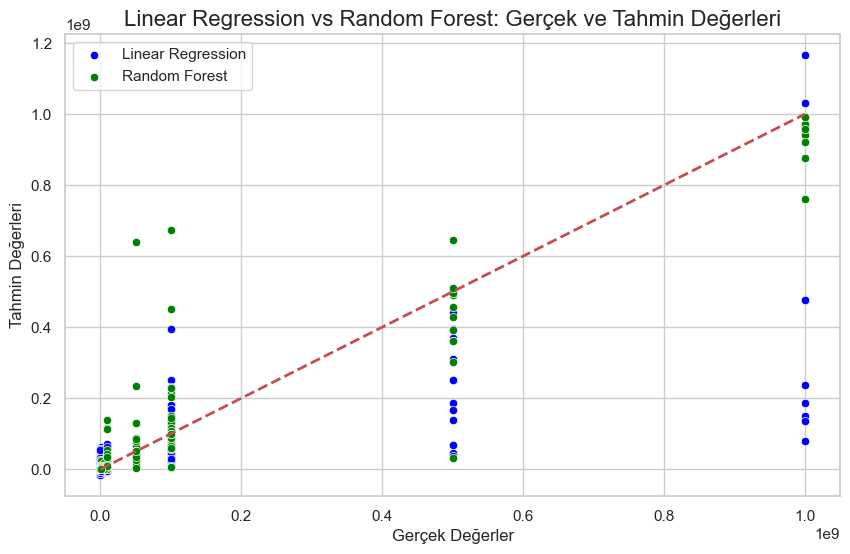

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Linear Regression ve Random Forest tahminlerini elde edelim
lr_y_pred = model.predict(X_test)  # Linear Regression tahminleri
rf_y_pred = rf_model.predict(X_test)  # Random Forest tahminleri

# Görselleştirme
plt.figure(figsize=(10, 6))

# Gerçek değerler ile tahminler karşılaştırması
sns.scatterplot(x=y_test, y=lr_y_pred, label='Linear Regression', color='blue')
sns.scatterplot(x=y_test, y=rf_y_pred, label='Random Forest', color='green')

# Gerçek değerleri gösteren referans çizgisi (y=x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# Başlık ve etiketler
plt.title('Linear Regression vs Random Forest: Gerçek ve Tahmin Değerleri', fontsize=16)
plt.xlabel('Gerçek Değerler', fontsize=12)
plt.ylabel('Tahmin Değerleri', fontsize=12)
plt.legend()

plt.show()


### Isı Haritası (Heatmap) ile Gerçek ve Tahmin Değerlerinin Korelasyonu

In [42]:
print(f"y_test length: {len(y_test)}")
print(f"lr_y_pred length: {len(lr_y_pred)}")
print(f"rf_y_pred length: {len(rf_y_pred)}")


y_test length: 1874
lr_y_pred length: 1874
rf_y_pred length: 1874


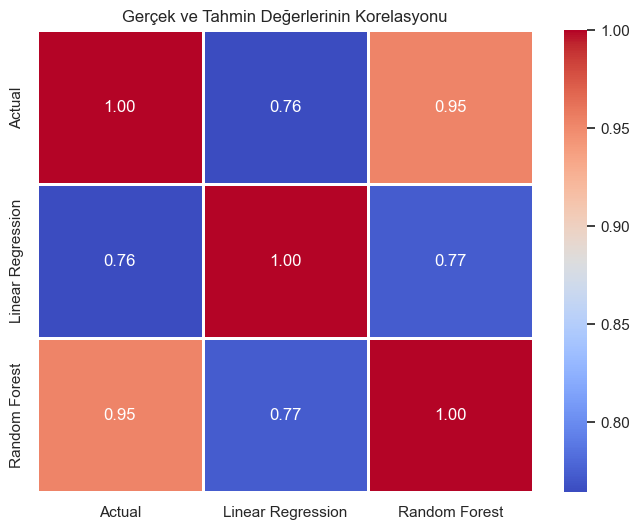

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Gerçek ve tahmin sonuçlarını birleştiriyoruz
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Linear Regression': lr_y_pred,
    'Random Forest': rf_y_pred
})

# Korelasyon hesaplıyoruz
corr_matrix = comparison_df.corr()

# Isı haritası ile görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1)
plt.title("Gerçek ve Tahmin Değerlerinin Korelasyonu")
plt.show()
